In [40]:
import numpy as np
from tqdm import tqdm
import trimesh
import open3d as o3d
import math

import matplotlib.pyplot as plt

import glob
import os, re
from omegaconf import OmegaConf
from collections import Counter
from skimage.filters import threshold_minimum
import scipy
import skimage
import seaborn as sns

In [2]:
# Helper-functions

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text) ]

def fibonacci_sphere(samples=2):
    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment
        x = math.cos(theta) * radius
        z = math.sin(theta) * radius
        points.append((x, y, z))

    return points

# Nothing to see here
def toIntAppended1D(data):
    int_1d = np.zeros((len(data)))
    for i in range(len(data)):
        s = data[i]
        int_1d[i] = int(str(s[0]) + str(s[1]) + str(s[2]))
    return int_1d

def List2Vec(lst, shape = (320,303,228)):
    vecs = np.reshape(lst, shape)
    vecs = np.array(np.where(vecs!=0)).T.astype(np.int16)
    return vecs

def Vec2List(vecs, shape = (320,303,228)):
    cube = np.zeros(shape)
    cube[vecs[:,0], vecs[:,1], vecs[:,2]] = 1
    lst = np.reshape(cube, -1)
    return lst
    #coords = np.moveaxis(np.indices(shape), 0, -1)

In [3]:
def coords2pc(coords, plot=True, color = [1,0,0]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(coords)

    pcd_colors = np.repeat([color],len(coords), axis=0)
    pcd.colors = o3d.utility.Vector3dVector(pcd_colors)

    pcd.estimate_normals()

    # Visualization-check
    if plot:
        o3d.visualization.draw_geometries([pcd])
        
    return pcd

def getNumHitPerCoord(locs, threshold=None):
    # count number of hits for each point in the point-cloud of the heart surface
    c = Counter(map(tuple, locs))

    coords = np.array(list(c.keys()))
    key_values = np.array(list(c.values()))   
    
    s_inds = toIntAppended1D(surface_inds)
    s_coords = toIntAppended1D(coords)
    s, a_inds, b_inds = np.intersect1d(s_inds, s_coords, return_indices=True)
    
    if threshold==None:
        lst = np.concatenate([surface_inds[a_inds], np.array([key_values[b_inds]]).T], axis=1)
    else:
        lst = np.concatenate([surface_inds[a_inds], np.array([key_values[b_inds]]).T>threshold], axis=1)
    return lst  
    
def counter2apearance(coords, values, threshold=12):
    s_inds = toIntAppended1D(surface_inds)
    s_coords = toIntAppended1D(coords)
    s, a_inds, b_inds = np.intersect1d(s_inds, s_coords, return_indices=True)
    
    print(np.array([values[b_inds]]).T.shape, surface_inds[a_inds].shape)
    lst = np.concatenate([surface_inds[a_inds], np.array([values[b_inds]]).T>threshold], axis=1)
    return lst

In [4]:
shape = (320,303,228) # set 3D discretisation

# Test of transformations
vecs = np.array([[120,201,200],[12,158,102], [10,0,2]])
List2Vec(Vec2List(vecs))

array([[ 10,   0,   2],
       [ 12, 158, 102],
       [120, 201, 200]], dtype=int16)

In [5]:
#file_geometry = '/home/roland/Projekte/HeartReconstruction/data/processed/Atrial_geometry'
file_surface = '/home/roland/Projekte/HeartReconstruction/data/processed/Heart_surface'

In [6]:
#geometry = np.fromfile(file_geometry, dtype=np.int32)
#heart_inds = List2Vec(geometry) # shape: [n,3], transposed list of 3D-vectors

surface = np.fromfile(file_surface, dtype=np.int32)
surface_inds = List2Vec(surface) # shape: [m,3], transposed list of 3D-vectors

In [7]:
# Generate o3d point cloud from the heart

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(surface_inds)
colors = np.ones((len(surface_inds), 3))*0.7
pcd.colors = o3d.utility.Vector3dVector(colors)
pcd.estimate_normals()

#o3d.io.write_point_cloud("heart.ply", pcd)

#o3d.visualization.draw_geometries([pcd], point_show_normal=False)

In [8]:
# Generate o3d-mesh from point cloud from the heart

radii = np.array([0.005, 0.01, 0.02, 0.04])*100
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))
#mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=7)
#mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, )

In [9]:
# Visualization-check
#o3d.visualization.draw_geometries([mesh])

In [10]:
# Generate Ray-tracer for ray-mesh-intersections

tri_mesh = trimesh.Trimesh(np.asarray(mesh.vertices), 
                           np.asarray(mesh.triangles),
                           vertex_normals=np.asarray(mesh.vertex_normals))

tracer = trimesh.ray.ray_pyembree.RayMeshIntersector(tri_mesh)

In [11]:
# Generate fibonacci points as enveloping sphere around the heart

num_points = 5000 # number of ray-origins around the heart
radius = 250 # arbitrary tuned
s_off = np.array([surface_inds[:,i].mean() for i in range(3)]) + np.array([-10,-20,0]) # manually tuned
points = np.array(fibonacci_sphere(num_points))*radius + s_off

#ex1 = np.array([surface_inds[:,i].max() for i in range(1,4)]) - np.array([surface_inds[:,i].mean() for i in range(1,4)])
#ex2 = np.array([surface_inds[:,i].min() for i in range(1,4)]) - np.array([surface_inds[:,i].mean() for i in range(1,4)])
#dmax = np.max(np.abs(ex1) + np.abs(ex2))#

In [12]:
# Generate o3d-point-cloud from fibonacci-sphere-point-cloud

sphere = o3d.geometry.PointCloud()
sphere.points = o3d.utility.Vector3dVector(points)
sphere.estimate_normals()

In [13]:
# Visualization-check
o3d.visualization.draw_geometries([sphere, pcd])

In [14]:
# origins are the previously defineds point on the enveloping sphere
# directions of the rays from ever origin are again points on a sphere:

num_dirs = 20000 # ( 1 000 000)
directions = np.array(fibonacci_sphere(num_dirs))
origins = points

In [15]:
# find ray-intersections for every origin with every direction

locs = []
for origin in tqdm(origins):
    _origins = np.repeat([origin], len(directions), axis=0)

    loc, _, _ = tracer.intersects_location(_origins, directions, multiple_hits=False)
    loc = (loc+0.5).astype(np.int16) # round intersection-coordinate to find the closest point at the surface
    locs.append(loc)
locs = np.concatenate(locs, axis=0)


100%|██████████| 5000/5000 [00:16<00:00, 311.97it/s]


In [16]:
# counts for each point at the heart surface how often it got hit by rays: [x,y,z,num_hits]
# if threshold!=None: set num_hits to 1 if number is above threshold
surface_inds_appearance = getNumHitPerCoord(locs, threshold=None)
surface_inds_appearance

array([[106,   9,  93,  23],
       [106,   9,  94,  34],
       [106,   9,  95,  50],
       ...,
       [289, 137, 105,  44],
       [289, 137, 106,  44],
       [289, 138, 102,  59]])

In [17]:
surface_inds_appearance.shape, surface_inds.shape

((256685, 4), (278477, 3))

In [18]:
s_inds = toIntAppended1D(surface_inds)
s_coords = toIntAppended1D(surface_inds_appearance[:,:3])
s, a_inds, b_inds = np.intersect1d(s_inds, s_coords, return_indices=True)
surface_inds_appearance_real = np.concatenate([surface_inds, np.zeros((len(surface_inds),1))], axis=1).astype(np.int16)
surface_inds_appearance_real[a_inds,3] = surface_inds_appearance[b_inds,3]
#surface_inds_appearance = surface_inds_appearance_real.copy()

In [19]:
surface_inds_appearance_real

array([[  2, 120, 119,  47],
       [  2, 120, 120,  39],
       [  2, 120, 121,  33],
       ...,
       [289, 137, 105,  44],
       [289, 137, 106,  44],
       [289, 138, 102,  59]], dtype=int16)

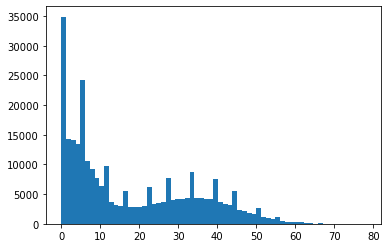

In [27]:
# visualization for threshold estimation (more hits -> more likely to be outer surface)
plt.hist(surface_inds_appearance_real[:,-1], bins=64)
plt.xlabel('Number of hits')
plt.show()

In [21]:
thresh_min = threshold_minimum(surface_inds_appearance_real[:,-1])
thresh_min

18

In [22]:
threshold = thresh_min
outer_surface_inds = surface_inds_appearance_real[surface_inds_appearance_real[:,-1]>threshold][:,:3]
inner_surface_inds = surface_inds_appearance_real[surface_inds_appearance_real[:,-1]<=threshold][:,:3]

In [23]:
outer = coords2pc(outer_surface_inds, plot=False, color=[1,0,0])
inner = coords2pc(inner_surface_inds, plot=False, color=[0,0,1])
o3d.visualization.draw_geometries([outer, inner])

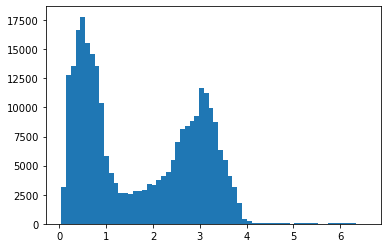

1.7550138


In [24]:
# a bit postprocessing

cube = np.zeros(shape).astype(np.float32)
coords = surface_inds_appearance_real[:,:3]
values = surface_inds_appearance_real[:,-1]
cube[coords[:,0],coords[:,1],coords[:,2]] = values

# filtering
cube_filtered = cube.copy()
    
cube_filtered = scipy.ndimage.convolve(cube_filtered, np.ones((3,3,3))/(3**3))
cube_filtered = scipy.ndimage.convolve(cube_filtered, np.ones((5,5,5))/(5**3))
cube_filtered = scipy.ndimage.convolve(cube_filtered, np.ones((7,7,7))/(7**3))
cube_filtered = scipy.ndimage.convolve(cube_filtered, np.ones((9,9,9))/(9**3))

new_values = cube_filtered[coords[:,0],coords[:,1],coords[:,2]]
plt.hist(new_values, bins=64)
plt.show()

thresh_min = threshold_minimum(new_values)
threshold = thresh_min
print(threshold)

In [25]:
cube_filtered = scipy.ndimage.convolve(cube_filtered, np.ones((11,11,11))/(11**3))

In [50]:
new_values.max()

5.178558

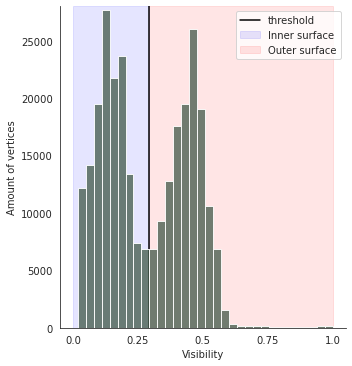

In [84]:
sns.set_style("white")
new_values = cube_filtered[coords[:,0],coords[:,1],coords[:,2]]
ax = sns.displot(new_values, bins=32, color='#405847', zorder=10)
plt.xticks(np.linspace(0,max(new_values), 5), np.linspace(0,1,5))
plt.yticks
plt.xlabel(r'Visibility')
plt.ylabel('Amount of vertices')

plt.ylim([0,28000])

plt.plot([1.52,1.52], [0,28000], label='threshold', color='#000000', zorder=9)

plt.axvspan(0, 1.52, color='#0000FF', alpha=0.1, zorder=-1, label='Inner surface')
plt.axvspan(1.52, new_values.max(), color='#FF0000', alpha=0.1, label='Outer surface')

plt.legend()

plt.savefig('hist_1.pdf', dpi=600)
plt.show()


In [24]:
outer = coords2pc(coords[new_values>1.4], plot=0, color=[1,0,0]) # threshold manually tuned
inner = coords2pc(coords[new_values<=1.4], plot=0, color=[0,0,1])
o3d.visualization.draw_geometries([outer, inner])

In [ ]:
outer_surface_list = Vec2List(coords[new_values>1.4]).astype(np.int8)
inner_surface_list = Vec2List(coords[new_values<=1.4]).astype(np.int8)

np.save('outer_surface', outer_surface_list)
np.save('inner_surface', inner_surface_list)

In [ ]:
np.cos(np.pi)